## Overview
1. Time series data analysis
2. Anomaly detection and resolution 
3. Forecast modeling using XGBoost
4. Causal DAG for model explainability and EDA

## Import libraries and data

In [254]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import holidays
import re
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import optuna
from xgboost import XGBRegressor

pd.set_option("display.max_columns", 101)

In [255]:
df = pd.read_csv('data/video_subscription.csv')

In [256]:
df.head()

,customer_id,created_date,canceled_date,subscription_cost,subscription_interval,was_subscription_paid
0,154536156.0,9/1/2022,NaN,39.0,month,Yes
1,149713408.0,9/1/2022,9/2/2022,39.0,month,No
2,153756284.0,9/1/2022,9/2/2022,39.0,month,No
3,121253113.0,9/1/2022,9/23/2022,39.0,month,Yes
4,154467210.0,9/1/2022,6/29/2023,39.0,month,Yes


In [257]:
df.shape

(3140, 6)

# Calculating daily subscribers

In [258]:
paid_subscribers = df[df['was_subscription_paid']=="Yes"]
non_paid_subscribers = df[df['was_subscription_paid']=="No"]

In [259]:
paid_subscribers['created_date'] = pd.to_datetime(paid_subscribers['created_date'])
daily_paid_subscriptions = paid_subscribers.groupby('created_date').size().reset_index(name='subscription_count')

C:\Users\parte\AppData\Local\Temp\ipykernel_31624\3221630230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paid_subscribers['created_date'] = pd.to_datetime(paid_subscribers['created_date'])


In [260]:
date_range = pd.date_range(start=daily_paid_subscriptions['created_date'].min(), end=daily_paid_subscriptions['created_date'].max())
complete_date_range = pd.DataFrame(date_range, columns=['created_date'])
daily_paid_subscriptions = complete_date_range.merge(daily_paid_subscriptions, on='created_date', how='left').fillna(0)
daily_paid_subscriptions['subscription_count'] = daily_paid_subscriptions['subscription_count'].astype(int)


## Visualizing subscription trend

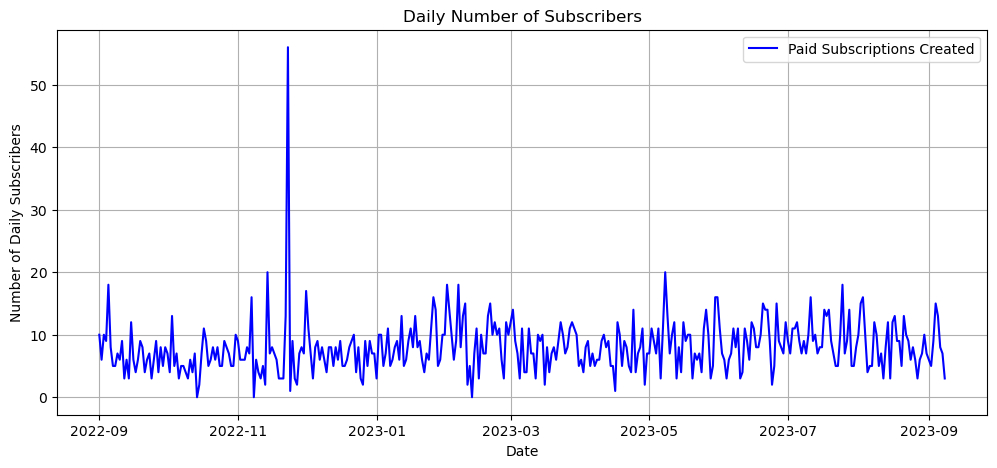

In [261]:
# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(daily_paid_subscriptions['created_date'], daily_paid_subscriptions['subscription_count'], label='Paid Subscriptions Created', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Daily Subscribers')
plt.title('Daily Number of Subscribers')
plt.legend()
plt.grid(True)
plt.show()

## Anomlay detection and Resolution

### Approach 1: Rolling standard deviations

In [262]:
data = daily_paid_subscriptions[['created_date', 'subscription_count']]
data.set_index('created_date', inplace=True)

rolling_deviations = pd.Series(dtype=float, index = data.index)

for date in rolling_deviations.index:
    window = data.loc[:date]
    
    rolling_deviations.at[date] = window.std()

In [263]:
#difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()

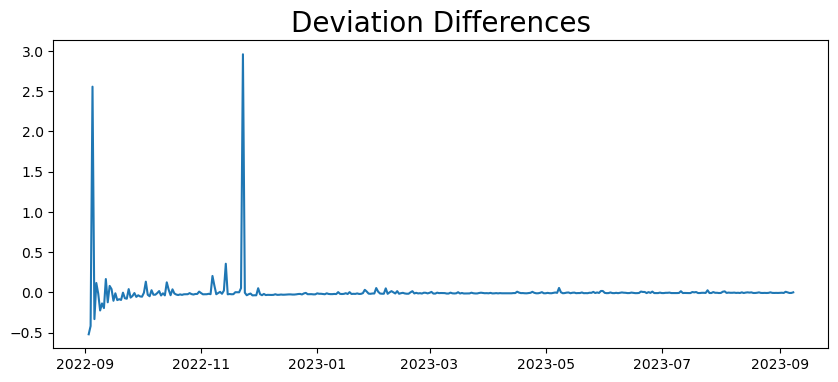

In [264]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.show()

### Approach 2: weekly or monthly devations

In [265]:
month_deviations = data.groupby(lambda d: d.month).std()

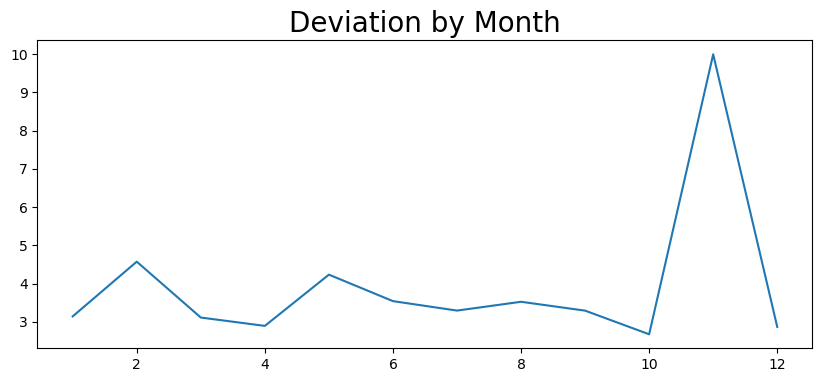

In [266]:
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month', fontsize=20)
plt.show()

In [267]:
weekly_deviations = data.groupby(lambda d: d.isocalendar().week).std()

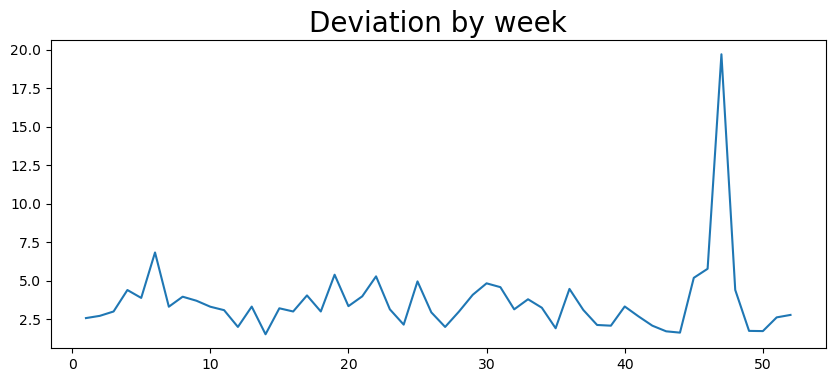

In [268]:
plt.figure(figsize=(10,4))
plt.plot(weekly_deviations)
plt.title('Deviation by week', fontsize=20)
plt.show()

### Anomaly Resolution

In [269]:
daily_paid_subscriptions

,created_date,subscription_count
0,2022-09-01,10
1,2022-09-02,6
2,2022-09-03,10
3,2022-09-04,9
4,2022-09-05,18
...,...,...
368,2023-09-04,15
369,2023-09-05,13
370,2023-09-06,8
371,2023-09-07,7


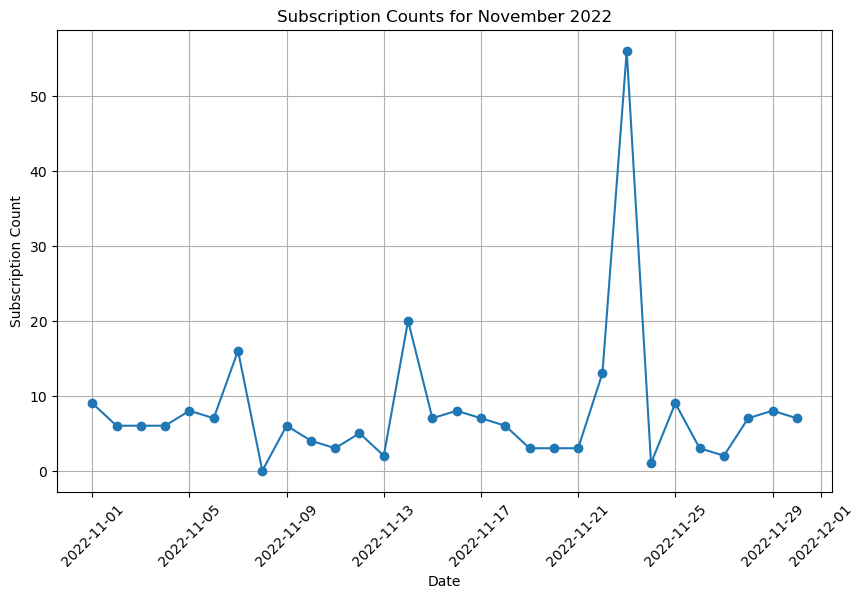

In [270]:
# Filter the data for November 2022
november_2022_data = daily_paid_subscriptions[(daily_paid_subscriptions['created_date'] >= '2022-11-01') & 
                                              (daily_paid_subscriptions['created_date'] <= '2022-11-30')]

# Plot the data for November 2022
plt.figure(figsize=(10, 6))
plt.plot(november_2022_data['created_date'], november_2022_data['subscription_count'], marker='o')
plt.title('Subscription Counts for November 2022')
plt.xlabel('Date')
plt.ylabel('Subscription Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [271]:
average_count = november_2022_data[
    (november_2022_data['created_date'] >= '2022-11-21') &
    (november_2022_data['created_date'] <= '2022-11-25') &
    (november_2022_data['created_date'] != '2022-11-23')
]['subscription_count'].mean()

In [272]:
daily_paid_subscriptions.loc[daily_paid_subscriptions['created_date'] == '2022-11-23', 
                             'subscription_count'] = int(average_count)

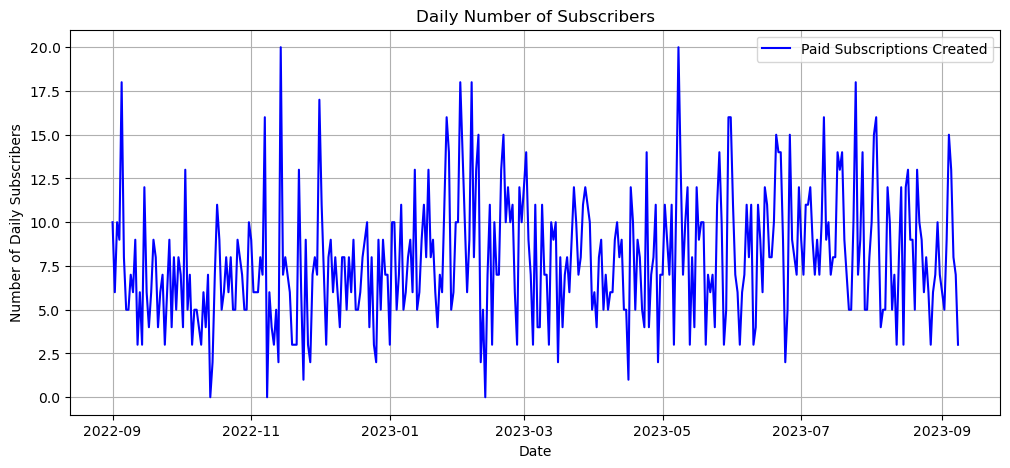

In [273]:
# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(daily_paid_subscriptions['created_date'], daily_paid_subscriptions['subscription_count'], label='Paid Subscriptions Created', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Daily Subscribers')
plt.title('Daily Number of Subscribers')
plt.legend()
plt.grid(True)
plt.show()

### Forecasting using XGBoost

In [274]:
daily_paid_subscriptions

,created_date,subscription_count
0,2022-09-01,10
1,2022-09-02,6
2,2022-09-03,10
3,2022-09-04,9
4,2022-09-05,18
...,...,...
368,2023-09-04,15
369,2023-09-05,13
370,2023-09-06,8
371,2023-09-07,7


In [275]:
daily_paid_subscriptions.rename(columns={'created_date':'timestamp'}, inplace=True)
df = daily_paid_subscriptions

In [276]:
def create_features(df):
    """
    Create time series features 
    """
    df = df.copy()
    # Date time features
    df['quarter'] = df['timestamp'].dt.quarter
    df['dayofmonth'] = df['timestamp'].dt.day
    df['is_weekend'] = (df['timestamp'].dt.dayofweek >= 5).astype(int)
    df['is_month_start'] = (df['timestamp'].dt.is_month_start).astype(int)
    df['is_month_end'] = (df['timestamp'].dt.is_month_end).astype(int)
    df['is_year_start'] = (df['timestamp'].dt.is_year_start).astype(int)
    df['is_year_end'] = (df['timestamp'].dt.is_year_end).astype(int)
    
    # Rolling features
    df['rolling_mean_7d'] = df['subscription_count'].rolling(window=7).mean()
    df['rolling_std_7d'] = df['subscription_count'].rolling(window=7).std()
    df['ewm_mean_7d'] = df['subscription_count'].ewm(span=7).mean()

    # Lag features
    df['lag_1'] = df['subscription_count'].shift(1)
    df['lag_2'] = df['subscription_count'].shift(2)
    df['lag_3'] = df['subscription_count'].shift(3)
    df['lag_7'] = df['subscription_count'].shift(7)
    
    # Holidays
    start_date = datetime(2022, 9, 1).date()
    end_date = datetime(2023, 9, 8).date()
    us_holidays = holidays.US(years=[2022, 2023])
    holidays_in_range = {date for date in us_holidays if start_date <= date <= end_date}
    df['is_holiday'] = df['timestamp'].isin(holidays_in_range).astype(int)
    
    return df

In [277]:
# Assuming df is your dataframe with a 'timestamp' column of datetime type and 'subscriptions' column
df = create_features(df)
df.head()

,timestamp,subscription_count,quarter,dayofmonth,is_weekend,is_month_start,is_month_end,is_year_start,is_year_end,rolling_mean_7d,rolling_std_7d,ewm_mean_7d,lag_1,lag_2,lag_3,lag_7,is_holiday
0,2022-09-01,10,3,1,0,1,0,0,0,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,0
1,2022-09-02,6,3,2,0,0,0,0,0,NaN,NaN,7.714286,10.0,NaN,NaN,NaN,0
2,2022-09-03,10,3,3,1,0,0,0,0,NaN,NaN,8.702703,6.0,10.0,NaN,NaN,0
3,2022-09-04,9,3,4,1,0,0,0,0,NaN,NaN,8.811429,10.0,6.0,10.0,NaN,0
4,2022-09-05,18,3,5,0,0,0,0,0,NaN,NaN,11.823303,9.0,10.0,6.0,NaN,1


### Remove outliers

In [278]:
q_low = df["subscription_count"].quantile(0.01)
q_hi  = df["subscription_count"].quantile(0.99)

df_filtered = df[(df["subscription_count"] < q_hi) & (df["subscription_count"] > q_low)]

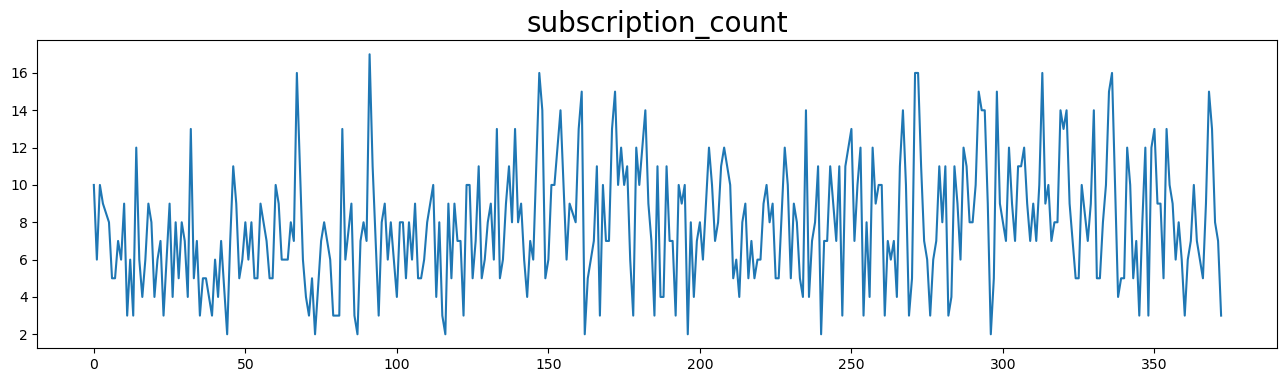

In [279]:
plt.figure(figsize=(16,4))
plt.plot(df_filtered['subscription_count'])
plt.title('subscription_count', fontsize=20)
plt.show()

In [280]:
df = df_filtered

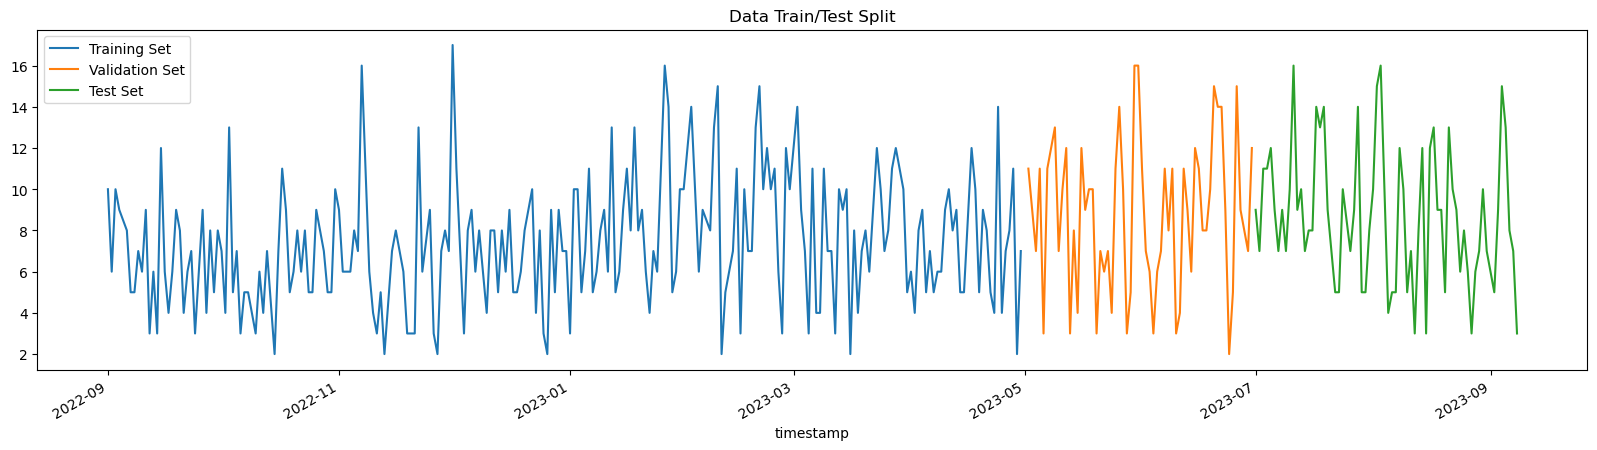

In [281]:
df.set_index('timestamp', inplace=True, drop=True)

train = df.loc[df.index < '2023-05-01 00:00:00']
val = df.loc[(df.index > '2023-05-01 00:00:00') & (df.index < '2023-07-01 00:00:00')]
test = df.loc[df.index >= '2023-07-01 00:00:00']

fig, ax = plt.subplots(figsize=(20, 5))
train["subscription_count"].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
val["subscription_count"].plot(ax=ax, label='Test Set')
test["subscription_count"].plot(ax=ax, label='val Set')
ax.legend(['Training Set', 'Validation Set' ,'Test Set'])
plt.show()

## Feature selection

### check multicolinearity

<Axes: >

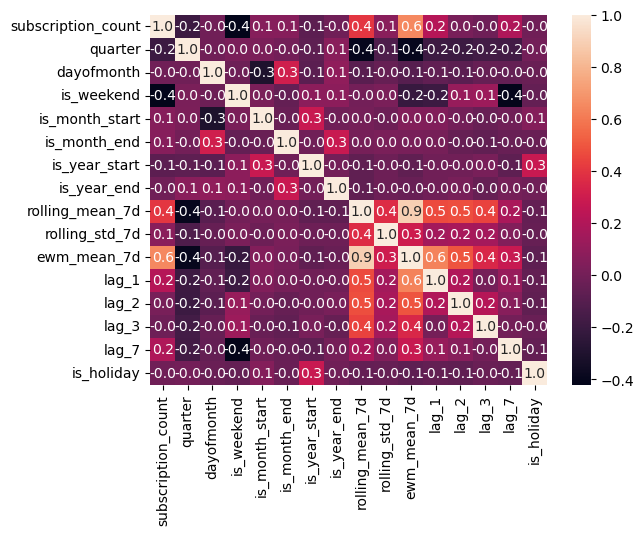

In [282]:
sns.heatmap(df.corr(), annot=True, fmt=".1f")

### Feature importance using xgboost

In [283]:
y_train = train['subscription_count']
X_train = train.drop("subscription_count", axis=1)

y_val = val['subscription_count']
X_val = val.drop("subscription_count", axis=1)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((233, 15), (233,), (59, 15), (59,))

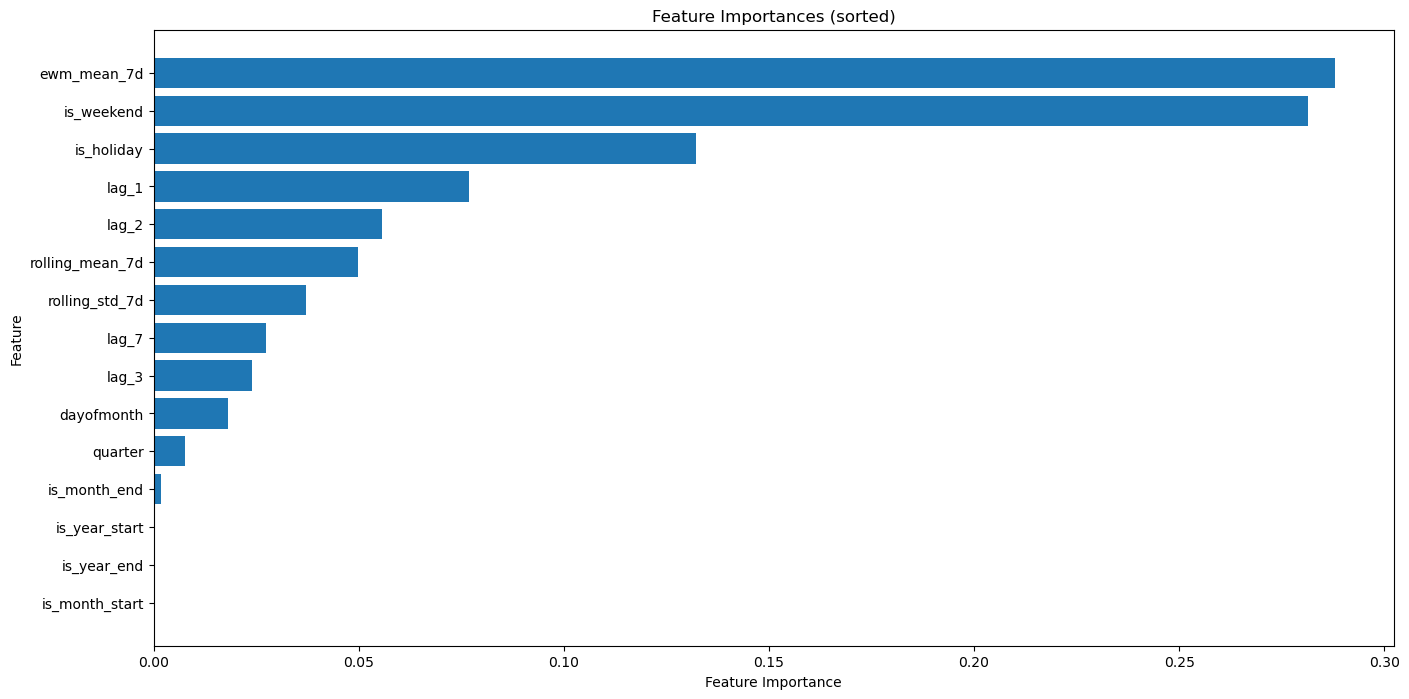

In [284]:
model = XGBRegressor()
model.fit(X_train, y_train)

# feature importances
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
})

importance_df = importance_df.sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(16, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (sorted)')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

In [285]:
df.columns

Index(['subscription_count', 'quarter', 'dayofmonth', 'is_weekend',
       'is_month_start', 'is_month_end', 'is_year_start', 'is_year_end',
       'rolling_mean_7d', 'rolling_std_7d', 'ewm_mean_7d', 'lag_1', 'lag_2',
       'lag_3', 'lag_7', 'is_holiday'],
      dtype='object')

In [288]:
selected_features = [
'ewm_mean_7d', 'is_holiday', 'is_weekend',
    'lag_1', 'lag_2', 'lag_7', 'lag_3',
    'rolling_mean_7d',
       'rolling_std_7d'
]

target = ['subscription_count']

## Hyperparameter tuning using Optuna

In [289]:
y_train = train['subscription_count']
X_train = train[selected_features]

y_val = val['subscription_count']
X_val = val[selected_features]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((233, 9), (233,), (59, 9), (59,))

In [302]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 1500, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.08, 0.12),  
        "max_depth": trial.suggest_int("max_depth",2,4),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.0, step=0.1),
        'gamma': trial.suggest_float('gamma', 0.2,0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0)
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_val)
    
    mape = mean_absolute_percentage_error(y_val, predictions)
    return mape

In [303]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

[I 2024-05-28 14:18:42,369] A new study created in memory with name: no-name-b1456371-4eaf-4642-b6a0-0140ba6aabd0
[I 2024-05-28 14:18:43,031] Trial 0 finished with value: 0.2485573005343871 and parameters: {'n_estimators': 1200, 'learning_rate': 0.11295698884649863, 'max_depth': 3, 'subsample': 0.8973924048727424, 'colsample_bytree': 0.8, 'gamma': 0.36245022392258885, 'reg_alpha': 0.345844201095141, 'reg_lambda': 0.23272511765836645}. Best is trial 0 with value: 0.2485573005343871.
[I 2024-05-28 14:18:43,282] Trial 1 finished with value: 0.25152071055861597 and parameters: {'n_estimators': 400, 'learning_rate': 0.10358329991114194, 'max_depth': 3, 'subsample': 0.8950003996615571, 'colsample_bytree': 1.0, 'gamma': 0.2850152963976628, 'reg_alpha': 0.8473018750059783, 'reg_lambda': 0.34654628009739363}. Best is trial 0 with value: 0.2485573005343871.
[I 2024-05-28 14:18:43,715] Trial 2 finished with value: 0.2064338026392388 and parameters: {'n_estimators': 1000, 'learning_rate': 0.106235

[I 2024-05-28 14:18:52,555] Trial 21 finished with value: 0.19462938127185128 and parameters: {'n_estimators': 1500, 'learning_rate': 0.09785558935796444, 'max_depth': 2, 'subsample': 0.8287271933856862, 'colsample_bytree': 0.9, 'gamma': 0.22809654017575934, 'reg_alpha': 0.11520544180261652, 'reg_lambda': 0.15267784337372653}. Best is trial 12 with value: 0.179739703767303.
[I 2024-05-28 14:18:53,074] Trial 22 finished with value: 0.19965531925054783 and parameters: {'n_estimators': 1400, 'learning_rate': 0.09618659271391748, 'max_depth': 2, 'subsample': 0.8218311999903993, 'colsample_bytree': 0.9, 'gamma': 0.2420231960287799, 'reg_alpha': 0.01572282380172017, 'reg_lambda': 0.2539948825893835}. Best is trial 12 with value: 0.179739703767303.
[I 2024-05-28 14:18:53,642] Trial 23 finished with value: 0.21226183413393473 and parameters: {'n_estimators': 1500, 'learning_rate': 0.10136565479852638, 'max_depth': 2, 'subsample': 0.8524048670371356, 'colsample_bytree': 1.0, 'gamma': 0.20084753

[I 2024-05-28 14:19:04,566] Trial 43 finished with value: 0.19378270179754378 and parameters: {'n_estimators': 1400, 'learning_rate': 0.09788530571378737, 'max_depth': 2, 'subsample': 0.8502473564900948, 'colsample_bytree': 0.9, 'gamma': 0.29981450137068116, 'reg_alpha': 0.3764903212219426, 'reg_lambda': 0.04999749520005857}. Best is trial 12 with value: 0.179739703767303.
[I 2024-05-28 14:19:05,117] Trial 44 finished with value: 0.19238722647886256 and parameters: {'n_estimators': 1500, 'learning_rate': 0.09772519586002969, 'max_depth': 2, 'subsample': 0.844156975121722, 'colsample_bytree': 0.9, 'gamma': 0.3057322182244461, 'reg_alpha': 0.38410698207995553, 'reg_lambda': 0.056970050052832275}. Best is trial 12 with value: 0.179739703767303.
[I 2024-05-28 14:19:05,639] Trial 45 finished with value: 0.1928616892903006 and parameters: {'n_estimators': 1400, 'learning_rate': 0.10613663656880068, 'max_depth': 2, 'subsample': 0.8503869848043655, 'colsample_bytree': 0.9, 'gamma': 0.303531513

[I 2024-05-28 14:19:16,193] Trial 65 finished with value: 0.1979179680815393 and parameters: {'n_estimators': 1400, 'learning_rate': 0.1039841622274333, 'max_depth': 2, 'subsample': 0.8308916316458975, 'colsample_bytree': 0.9, 'gamma': 0.295673170713087, 'reg_alpha': 0.5012464058378023, 'reg_lambda': 0.08751208584832681}. Best is trial 58 with value: 0.17927246528732.
[I 2024-05-28 14:19:16,744] Trial 66 finished with value: 0.18397198639883075 and parameters: {'n_estimators': 1300, 'learning_rate': 0.10603519349398982, 'max_depth': 2, 'subsample': 0.8066422149477255, 'colsample_bytree': 1.0, 'gamma': 0.2716195874617479, 'reg_alpha': 0.45067324328972425, 'reg_lambda': 0.3162010633674337}. Best is trial 58 with value: 0.17927246528732.
[I 2024-05-28 14:19:17,248] Trial 67 finished with value: 0.1955610975668743 and parameters: {'n_estimators': 1200, 'learning_rate': 0.10187824994201575, 'max_depth': 2, 'subsample': 0.8064967104890852, 'colsample_bytree': 0.9, 'gamma': 0.2761949228526998

[I 2024-05-28 14:19:27,831] Trial 87 finished with value: 0.19920571138119803 and parameters: {'n_estimators': 1500, 'learning_rate': 0.10402855478263193, 'max_depth': 2, 'subsample': 0.8145074458077106, 'colsample_bytree': 0.9, 'gamma': 0.29423915200218725, 'reg_alpha': 0.4783119470211461, 'reg_lambda': 0.2630435236529834}. Best is trial 58 with value: 0.17927246528732.
[I 2024-05-28 14:19:28,434] Trial 88 finished with value: 0.18830678614494736 and parameters: {'n_estimators': 1500, 'learning_rate': 0.10841612883602386, 'max_depth': 2, 'subsample': 0.8000296379509755, 'colsample_bytree': 0.9, 'gamma': 0.25589172511806063, 'reg_alpha': 0.29151506629941715, 'reg_lambda': 0.19637713594266965}. Best is trial 58 with value: 0.17927246528732.
[I 2024-05-28 14:19:29,062] Trial 89 finished with value: 0.19653817692964293 and parameters: {'n_estimators': 1500, 'learning_rate': 0.10701493884242316, 'max_depth': 2, 'subsample': 0.8007287715432799, 'colsample_bytree': 0.9, 'gamma': 0.2582915074

[I 2024-05-28 14:19:41,548] Trial 109 finished with value: 0.20116853089820927 and parameters: {'n_estimators': 1200, 'learning_rate': 0.10642304685032276, 'max_depth': 2, 'subsample': 0.8185491004904806, 'colsample_bytree': 0.9, 'gamma': 0.23978211160168833, 'reg_alpha': 0.32663791836843037, 'reg_lambda': 0.058321399985092434}. Best is trial 58 with value: 0.17927246528732.
[I 2024-05-28 14:19:42,198] Trial 110 finished with value: 0.20678488622216917 and parameters: {'n_estimators': 1500, 'learning_rate': 0.11217688070873152, 'max_depth': 2, 'subsample': 0.8322133460936421, 'colsample_bytree': 0.9, 'gamma': 0.31970525937800187, 'reg_alpha': 0.37344755340948005, 'reg_lambda': 0.113264065614721}. Best is trial 58 with value: 0.17927246528732.
[I 2024-05-28 14:19:42,839] Trial 111 finished with value: 0.20498817349422363 and parameters: {'n_estimators': 1500, 'learning_rate': 0.09857767082440881, 'max_depth': 2, 'subsample': 0.8030889962016873, 'colsample_bytree': 0.9, 'gamma': 0.309327

[I 2024-05-28 14:19:55,519] Trial 131 finished with value: 0.19426314723957688 and parameters: {'n_estimators': 1300, 'learning_rate': 0.11575079268966144, 'max_depth': 2, 'subsample': 0.8002541306276599, 'colsample_bytree': 0.9, 'gamma': 0.25261035959242617, 'reg_alpha': 0.11779386256767088, 'reg_lambda': 0.013248189366277363}. Best is trial 58 with value: 0.17927246528732.
[I 2024-05-28 14:19:56,052] Trial 132 finished with value: 0.1891757927091613 and parameters: {'n_estimators': 1300, 'learning_rate': 0.11714556714081555, 'max_depth': 2, 'subsample': 0.8080979333769142, 'colsample_bytree': 0.9, 'gamma': 0.23621750176087686, 'reg_alpha': 0.1639721603743125, 'reg_lambda': 0.05323479315675815}. Best is trial 58 with value: 0.17927246528732.
[I 2024-05-28 14:19:56,596] Trial 133 finished with value: 0.19152845772846067 and parameters: {'n_estimators': 1300, 'learning_rate': 0.11752558249027435, 'max_depth': 2, 'subsample': 0.809598253851162, 'colsample_bytree': 0.9, 'gamma': 0.2342190

[I 2024-05-28 14:20:10,067] Trial 153 finished with value: 0.1886345941544401 and parameters: {'n_estimators': 1400, 'learning_rate': 0.1199662515946594, 'max_depth': 2, 'subsample': 0.8043691663056846, 'colsample_bytree': 0.9, 'gamma': 0.22593792194413817, 'reg_alpha': 0.0564537162084133, 'reg_lambda': 0.2211233526054259}. Best is trial 152 with value: 0.17922695377448192.
[I 2024-05-28 14:20:10,734] Trial 154 finished with value: 0.19735081951200698 and parameters: {'n_estimators': 1400, 'learning_rate': 0.11813803453031725, 'max_depth': 2, 'subsample': 0.809312192236988, 'colsample_bytree': 0.9, 'gamma': 0.2199951014969339, 'reg_alpha': 0.014523643708234118, 'reg_lambda': 0.27322327253219975}. Best is trial 152 with value: 0.17922695377448192.
[I 2024-05-28 14:20:11,346] Trial 155 finished with value: 0.19312005735771423 and parameters: {'n_estimators': 1400, 'learning_rate': 0.11620321483549352, 'max_depth': 2, 'subsample': 0.8047219959809015, 'colsample_bytree': 0.9, 'gamma': 0.20

[I 2024-05-28 14:20:24,310] Trial 174 finished with value: 0.19759731476975761 and parameters: {'n_estimators': 1500, 'learning_rate': 0.1177450322923236, 'max_depth': 2, 'subsample': 0.8097696264376485, 'colsample_bytree': 0.9, 'gamma': 0.21755743541892997, 'reg_alpha': 0.09892328662611313, 'reg_lambda': 0.2998293064338001}. Best is trial 156 with value: 0.17493064561446198.
[I 2024-05-28 14:20:24,947] Trial 175 finished with value: 0.19074104862431165 and parameters: {'n_estimators': 1400, 'learning_rate': 0.11643548386548279, 'max_depth': 2, 'subsample': 0.8040899798985733, 'colsample_bytree': 0.9, 'gamma': 0.2222283210779564, 'reg_alpha': 0.13291398096281842, 'reg_lambda': 0.2610764417476359}. Best is trial 156 with value: 0.17493064561446198.
[I 2024-05-28 14:20:25,636] Trial 176 finished with value: 0.18998743286099726 and parameters: {'n_estimators': 1500, 'learning_rate': 0.11995414109694487, 'max_depth': 2, 'subsample': 0.813548483959084, 'colsample_bytree': 0.9, 'gamma': 0.20

[I 2024-05-28 14:20:38,518] Trial 195 finished with value: 0.23191923330054223 and parameters: {'n_estimators': 800, 'learning_rate': 0.11533753736972627, 'max_depth': 3, 'subsample': 0.8038423894623904, 'colsample_bytree': 1.0, 'gamma': 0.21625169057077556, 'reg_alpha': 0.25831863287646056, 'reg_lambda': 0.3268310539950825}. Best is trial 156 with value: 0.17493064561446198.
[I 2024-05-28 14:20:39,160] Trial 196 finished with value: 0.20723401421782986 and parameters: {'n_estimators': 1400, 'learning_rate': 0.11965429090843965, 'max_depth': 2, 'subsample': 0.8109737191082018, 'colsample_bytree': 1.0, 'gamma': 0.20586356359998684, 'reg_alpha': 0.2092203955722236, 'reg_lambda': 0.2754115503652367}. Best is trial 156 with value: 0.17493064561446198.
[I 2024-05-28 14:20:39,799] Trial 197 finished with value: 0.196661445536184 and parameters: {'n_estimators': 1400, 'learning_rate': 0.1161938083296726, 'max_depth': 2, 'subsample': 0.8067748221169052, 'colsample_bytree': 1.0, 'gamma': 0.2109

[I 2024-05-28 14:20:51,500] Trial 216 finished with value: 0.20390750979069494 and parameters: {'n_estimators': 600, 'learning_rate': 0.11873359772417955, 'max_depth': 2, 'subsample': 0.800959997221209, 'colsample_bytree': 1.0, 'gamma': 0.24359502850832485, 'reg_alpha': 0.18044105538446373, 'reg_lambda': 0.42093565908799724}. Best is trial 156 with value: 0.17493064561446198.
[I 2024-05-28 14:20:51,940] Trial 217 finished with value: 0.1982418431519445 and parameters: {'n_estimators': 700, 'learning_rate': 0.11997041646815214, 'max_depth': 2, 'subsample': 0.8689565940509034, 'colsample_bytree': 1.0, 'gamma': 0.24699073656849824, 'reg_alpha': 0.2505367061212481, 'reg_lambda': 0.40611449006048833}. Best is trial 156 with value: 0.17493064561446198.
[I 2024-05-28 14:20:52,453] Trial 218 finished with value: 0.22790272906332487 and parameters: {'n_estimators': 700, 'learning_rate': 0.11929039978936386, 'max_depth': 3, 'subsample': 0.8041210641045117, 'colsample_bytree': 1.0, 'gamma': 0.238

[I 2024-05-28 14:21:00,098] Trial 237 finished with value: 0.17952621617006598 and parameters: {'n_estimators': 700, 'learning_rate': 0.11303636066986514, 'max_depth': 2, 'subsample': 0.8071106230958074, 'colsample_bytree': 1.0, 'gamma': 0.24033176524677952, 'reg_alpha': 0.24763552850453152, 'reg_lambda': 0.4262843261908706}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:21:00,501] Trial 238 finished with value: 0.19014488927889175 and parameters: {'n_estimators': 700, 'learning_rate': 0.11374014502555457, 'max_depth': 2, 'subsample': 0.8124333564918423, 'colsample_bytree': 1.0, 'gamma': 0.24062778441839835, 'reg_alpha': 0.2443574579327995, 'reg_lambda': 0.4264814215531571}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:21:00,905] Trial 239 finished with value: 0.2018970051426076 and parameters: {'n_estimators': 700, 'learning_rate': 0.11236580355178793, 'max_depth': 2, 'subsample': 0.8040608087413901, 'colsample_bytree': 1.0, 'gamma': 0.2519

[I 2024-05-28 14:21:08,798] Trial 258 finished with value: 0.193162010760982 and parameters: {'n_estimators': 700, 'learning_rate': 0.11088630918914028, 'max_depth': 2, 'subsample': 0.8434103046220088, 'colsample_bytree': 1.0, 'gamma': 0.35840617525094903, 'reg_alpha': 0.253114159724293, 'reg_lambda': 0.36823078386874736}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:21:09,261] Trial 259 finished with value: 0.20246872164676402 and parameters: {'n_estimators': 800, 'learning_rate': 0.09796332246291259, 'max_depth': 2, 'subsample': 0.8061908006362082, 'colsample_bytree': 1.0, 'gamma': 0.22830785433434717, 'reg_alpha': 0.2140450878030163, 'reg_lambda': 0.41756921876078423}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:21:09,712] Trial 260 finished with value: 0.24980366587007974 and parameters: {'n_estimators': 600, 'learning_rate': 0.11332503619132873, 'max_depth': 4, 'subsample': 0.8329461631420678, 'colsample_bytree': 1.0, 'gamma': 0.24431

[I 2024-05-28 14:21:17,623] Trial 279 finished with value: 0.19628817901632573 and parameters: {'n_estimators': 700, 'learning_rate': 0.11545952904870709, 'max_depth': 2, 'subsample': 0.8127530032192525, 'colsample_bytree': 1.0, 'gamma': 0.22652292222747217, 'reg_alpha': 0.20552561198291353, 'reg_lambda': 0.20046969578259152}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:21:18,297] Trial 280 finished with value: 0.19167910921856696 and parameters: {'n_estimators': 1500, 'learning_rate': 0.1165639661557377, 'max_depth': 2, 'subsample': 0.8487524709479853, 'colsample_bytree': 1.0, 'gamma': 0.26008407981559817, 'reg_alpha': 0.2593812390052147, 'reg_lambda': 0.4783929154750203}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:21:18,752] Trial 281 finished with value: 0.20180190944622917 and parameters: {'n_estimators': 800, 'learning_rate': 0.11818147191063258, 'max_depth': 2, 'subsample': 0.803976501683352, 'colsample_bytree': 1.0, 'gamma': 0.322

[I 2024-05-28 14:21:30,274] Trial 300 finished with value: 0.19938927233006196 and parameters: {'n_estimators': 1500, 'learning_rate': 0.08101041743049929, 'max_depth': 2, 'subsample': 0.8138933484028629, 'colsample_bytree': 1.0, 'gamma': 0.2476408673295327, 'reg_alpha': 0.036624522470812146, 'reg_lambda': 0.24038519715294376}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:21:30,954] Trial 301 finished with value: 0.2037979176601447 and parameters: {'n_estimators': 1400, 'learning_rate': 0.09249361950237371, 'max_depth': 2, 'subsample': 0.9225766041737841, 'colsample_bytree': 0.8, 'gamma': 0.30673713534952163, 'reg_alpha': 0.47029956999564176, 'reg_lambda': 0.3756588235715098}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:21:31,391] Trial 302 finished with value: 0.18727357913264275 and parameters: {'n_estimators': 700, 'learning_rate': 0.11444634596414391, 'max_depth': 2, 'subsample': 0.8039497020126947, 'colsample_bytree': 1.0, 'gamma': 0.

[I 2024-05-28 14:21:42,745] Trial 321 finished with value: 0.19227579969297642 and parameters: {'n_estimators': 600, 'learning_rate': 0.10128443216456673, 'max_depth': 2, 'subsample': 0.8001179386896555, 'colsample_bytree': 1.0, 'gamma': 0.2172405350821145, 'reg_alpha': 0.34175529832209484, 'reg_lambda': 0.41253617598573633}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:21:43,485] Trial 322 finished with value: 0.19026398000423614 and parameters: {'n_estimators': 1500, 'learning_rate': 0.11790504858024194, 'max_depth': 2, 'subsample': 0.8070624926136781, 'colsample_bytree': 0.9, 'gamma': 0.23758476230983136, 'reg_alpha': 0.4137197452614981, 'reg_lambda': 0.03603081121668323}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:21:44,154] Trial 323 finished with value: 0.18912699088874174 and parameters: {'n_estimators': 1400, 'learning_rate': 0.11501250631049932, 'max_depth': 2, 'subsample': 0.8146407466052177, 'colsample_bytree': 1.0, 'gamma': 0.

[I 2024-05-28 14:21:55,537] Trial 342 finished with value: 0.19184395860527928 and parameters: {'n_estimators': 800, 'learning_rate': 0.11299998227412336, 'max_depth': 2, 'subsample': 0.8714546303436779, 'colsample_bytree': 0.9, 'gamma': 0.23412396054214193, 'reg_alpha': 0.40247385960099463, 'reg_lambda': 0.42093043709453987}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:21:55,970] Trial 343 finished with value: 0.18421428328838294 and parameters: {'n_estimators': 700, 'learning_rate': 0.10953503279380349, 'max_depth': 2, 'subsample': 0.8265331087911502, 'colsample_bytree': 1.0, 'gamma': 0.22687904650793828, 'reg_alpha': 0.4484019418706304, 'reg_lambda': 0.40299672214237464}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:21:56,407] Trial 344 finished with value: 0.1912860631232245 and parameters: {'n_estimators': 700, 'learning_rate': 0.11067653480404485, 'max_depth': 2, 'subsample': 0.8387099090367297, 'colsample_bytree': 1.0, 'gamma': 0.27

[I 2024-05-28 14:22:05,082] Trial 363 finished with value: 0.1934079603599875 and parameters: {'n_estimators': 1400, 'learning_rate': 0.11216820531409097, 'max_depth': 2, 'subsample': 0.8033537853762124, 'colsample_bytree': 0.9, 'gamma': 0.29105444631797217, 'reg_alpha': 0.36128417135652896, 'reg_lambda': 0.5976165445293105}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:22:05,470] Trial 364 finished with value: 0.20253281719289234 and parameters: {'n_estimators': 700, 'learning_rate': 0.09765626445198632, 'max_depth': 2, 'subsample': 0.8117543681156636, 'colsample_bytree': 1.0, 'gamma': 0.205549274216904, 'reg_alpha': 0.4851605818296825, 'reg_lambda': 0.19572008306808167}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:22:05,797] Trial 365 finished with value: 0.20366903193488398 and parameters: {'n_estimators': 600, 'learning_rate': 0.1191198234489247, 'max_depth': 2, 'subsample': 0.8366766897561398, 'colsample_bytree': 1.0, 'gamma': 0.23807

[I 2024-05-28 14:22:17,016] Trial 384 finished with value: 0.19854206699048446 and parameters: {'n_estimators': 900, 'learning_rate': 0.11279538166833257, 'max_depth': 2, 'subsample': 0.8000190567966788, 'colsample_bytree': 0.9, 'gamma': 0.28134624913420925, 'reg_alpha': 0.34627301737926397, 'reg_lambda': 0.37830040785687924}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:22:17,740] Trial 385 finished with value: 0.1879266250072758 and parameters: {'n_estimators': 1500, 'learning_rate': 0.09676065549653064, 'max_depth': 2, 'subsample': 0.805641216730736, 'colsample_bytree': 1.0, 'gamma': 0.22490819507738324, 'reg_alpha': 0.26286037579907584, 'reg_lambda': 0.27340015966740294}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:22:18,167] Trial 386 finished with value: 0.19161295914123772 and parameters: {'n_estimators': 800, 'learning_rate': 0.10031977261535503, 'max_depth': 2, 'subsample': 0.8104104557642956, 'colsample_bytree': 1.0, 'gamma': 0.2

[I 2024-05-28 14:22:30,734] Trial 405 finished with value: 0.2057512077216617 and parameters: {'n_estimators': 1500, 'learning_rate': 0.11313794982148978, 'max_depth': 2, 'subsample': 0.8803265330405668, 'colsample_bytree': 1.0, 'gamma': 0.26375851836814496, 'reg_alpha': 0.16984328990905126, 'reg_lambda': 0.09446436404239505}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:22:31,477] Trial 406 finished with value: 0.19508198639351512 and parameters: {'n_estimators': 1500, 'learning_rate': 0.11140828546371181, 'max_depth': 2, 'subsample': 0.8511398070710335, 'colsample_bytree': 1.0, 'gamma': 0.2873676544210912, 'reg_alpha': 0.22169548202888378, 'reg_lambda': 0.07359464707807511}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:22:32,230] Trial 407 finished with value: 0.19905198274347308 and parameters: {'n_estimators': 1500, 'learning_rate': 0.1144207406356866, 'max_depth': 2, 'subsample': 0.8094015166367083, 'colsample_bytree': 0.9, 'gamma': 0.

[I 2024-05-28 14:22:45,527] Trial 426 finished with value: 0.19015141485011602 and parameters: {'n_estimators': 1500, 'learning_rate': 0.11804010475366403, 'max_depth': 2, 'subsample': 0.8154368808013445, 'colsample_bytree': 1.0, 'gamma': 0.24451347263615833, 'reg_alpha': 0.3236484592128719, 'reg_lambda': 0.2948779497116966}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:22:46,197] Trial 427 finished with value: 0.19154923745806715 and parameters: {'n_estimators': 1400, 'learning_rate': 0.09451731635701519, 'max_depth': 2, 'subsample': 0.8035399294506191, 'colsample_bytree': 1.0, 'gamma': 0.2530942060060063, 'reg_alpha': 0.010869614799430168, 'reg_lambda': 0.5168390033690263}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:22:46,701] Trial 428 finished with value: 0.18813569615878986 and parameters: {'n_estimators': 900, 'learning_rate': 0.11395665866703494, 'max_depth': 2, 'subsample': 0.8475047567785507, 'colsample_bytree': 1.0, 'gamma': 0.2

[I 2024-05-28 14:22:58,790] Trial 447 finished with value: 0.1932544537392392 and parameters: {'n_estimators': 1200, 'learning_rate': 0.10781516506326594, 'max_depth': 2, 'subsample': 0.834737719184148, 'colsample_bytree': 1.0, 'gamma': 0.22822956733573804, 'reg_alpha': 0.22354133809576138, 'reg_lambda': 0.9965221983688368}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:22:59,533] Trial 448 finished with value: 0.18859672593675172 and parameters: {'n_estimators': 1400, 'learning_rate': 0.10462880050357928, 'max_depth': 2, 'subsample': 0.844769613355134, 'colsample_bytree': 1.0, 'gamma': 0.2332941135404894, 'reg_alpha': 0.2418520463887751, 'reg_lambda': 0.9474914790968166}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:23:00,591] Trial 449 finished with value: 0.24497215026442687 and parameters: {'n_estimators': 1300, 'learning_rate': 0.10731625927704412, 'max_depth': 4, 'subsample': 0.806284435001312, 'colsample_bytree': 1.0, 'gamma': 0.24074

[I 2024-05-28 14:23:13,034] Trial 468 finished with value: 0.18884469681975546 and parameters: {'n_estimators': 1400, 'learning_rate': 0.10647960493880455, 'max_depth': 2, 'subsample': 0.8497586438302276, 'colsample_bytree': 0.9, 'gamma': 0.2247393216041321, 'reg_alpha': 0.08118589861375082, 'reg_lambda': 0.9297814477821158}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:23:13,693] Trial 469 finished with value: 0.18353181171027133 and parameters: {'n_estimators': 1400, 'learning_rate': 0.10723958195960129, 'max_depth': 2, 'subsample': 0.8827883313277998, 'colsample_bytree': 1.0, 'gamma': 0.24528722770678463, 'reg_alpha': 0.09039467078262992, 'reg_lambda': 0.9791313107303768}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:23:14,364] Trial 470 finished with value: 0.18541149094243772 and parameters: {'n_estimators': 1300, 'learning_rate': 0.10164769484436358, 'max_depth': 2, 'subsample': 0.8398147245943763, 'colsample_bytree': 1.0, 'gamma': 0.

[I 2024-05-28 14:23:26,510] Trial 489 finished with value: 0.18986198625282416 and parameters: {'n_estimators': 1200, 'learning_rate': 0.1176153925791325, 'max_depth': 2, 'subsample': 0.8076942939073005, 'colsample_bytree': 1.0, 'gamma': 0.3566047167006849, 'reg_alpha': 0.35935090736278813, 'reg_lambda': 0.91587707862245}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:23:27,425] Trial 490 finished with value: 0.20158582597853275 and parameters: {'n_estimators': 1300, 'learning_rate': 0.08910092493405124, 'max_depth': 2, 'subsample': 0.8112317064495402, 'colsample_bytree': 0.9, 'gamma': 0.2556286337602541, 'reg_alpha': 0.2496991478878628, 'reg_lambda': 0.23838175747143345}. Best is trial 229 with value: 0.17108057246842376.
[I 2024-05-28 14:23:28,268] Trial 491 finished with value: 0.19139350862099455 and parameters: {'n_estimators': 1400, 'learning_rate': 0.11667759257877047, 'max_depth': 2, 'subsample': 0.8543965386996182, 'colsample_bytree': 1.0, 'gamma': 0.2417

In [304]:
study.best_trial

FrozenTrial(number=229, state=TrialState.COMPLETE, values=[0.17108057246842376], datetime_start=datetime.datetime(2024, 5, 28, 14, 20, 56, 428816), datetime_complete=datetime.datetime(2024, 5, 28, 14, 20, 56, 878609), params={'n_estimators': 800, 'learning_rate': 0.11315180638093202, 'max_depth': 2, 'subsample': 0.8072933970753412, 'colsample_bytree': 1.0, 'gamma': 0.2520743700576552, 'reg_alpha': 0.28023932727900047, 'reg_lambda': 0.4526701304993674}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1500, log=False, low=400, step=100), 'learning_rate': FloatDistribution(high=0.12, log=False, low=0.08, step=None), 'max_depth': IntDistribution(high=4, log=False, low=2, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.8, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.8, step=0.1), 'gamma': FloatDistribution(high=0.5, log=False, low=0.2, step=None), 'reg_alpha': FloatDistribution(hig

In [305]:
study.best_params

{'n_estimators': 800,
 'learning_rate': 0.11315180638093202,
 'max_depth': 2,
 'subsample': 0.8072933970753412,
 'colsample_bytree': 1.0,
 'gamma': 0.2520743700576552,
 'reg_alpha': 0.28023932727900047,
 'reg_lambda': 0.4526701304993674}

In [306]:
# params = {'n_estimators': 900,
#  'learning_rate': 0.09841122522859098,
#  'max_depth': 2,
#  'subsample': 0.8086864217476625,
#  'colsample_bytree': 1.0,
#  'gamma': 0.2201663011083917,
#  'reg_alpha': 0.6755277677086857,
#  'reg_lambda': 0.9290763995381841}

In [307]:
model = xgb.XGBRegressor(**study.best_params) 

In [308]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.2520743700576552,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.11315180638093202,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## performance on validation set

In [309]:
preds = model.predict(X_val)
val['predictions'] = preds

C:\Users\parte\AppData\Local\Temp\ipykernel_31624\3166128342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['predictions'] = preds


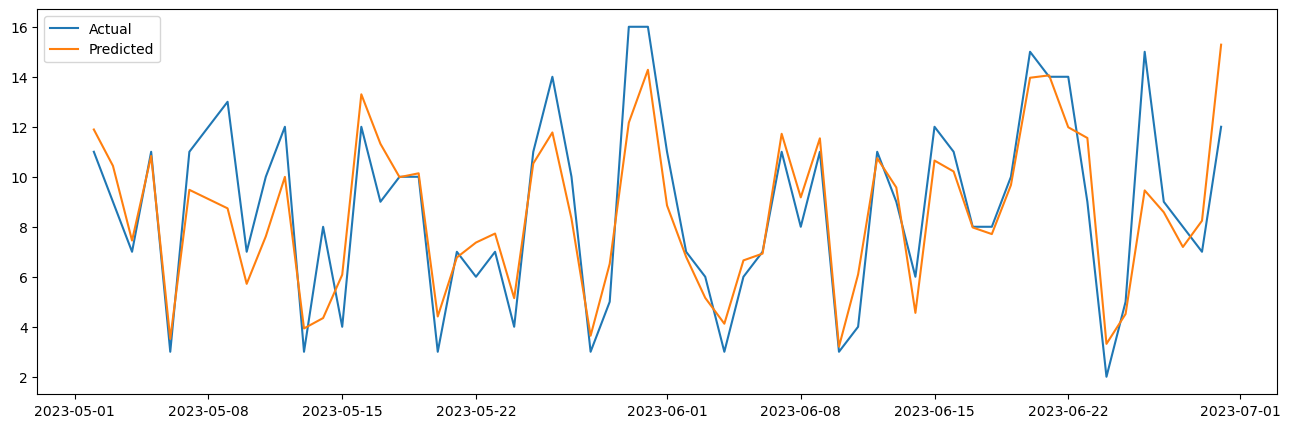

In [310]:
plt.figure(figsize=(16,5))
plt.plot(val.index, val['subscription_count'], label='Actual')
plt.plot(val.index, val['predictions'], label='Predicted')
plt.legend()

In [311]:
# data = df.loc[df.index < '2023-07-01 00:00:00']
# y = data['subscription_count']
# X = data[selected_features]

# model.fit(X, y)

## performance on test set

In [312]:
temp = test[selected_features]

preds = model.predict(temp)
test['predictions'] = preds

mape = mean_absolute_percentage_error(test['subscription_count'], preds)
print(mape)

0.1527184157863216


C:\Users\parte\AppData\Local\Temp\ipykernel_31624\4197734782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = preds


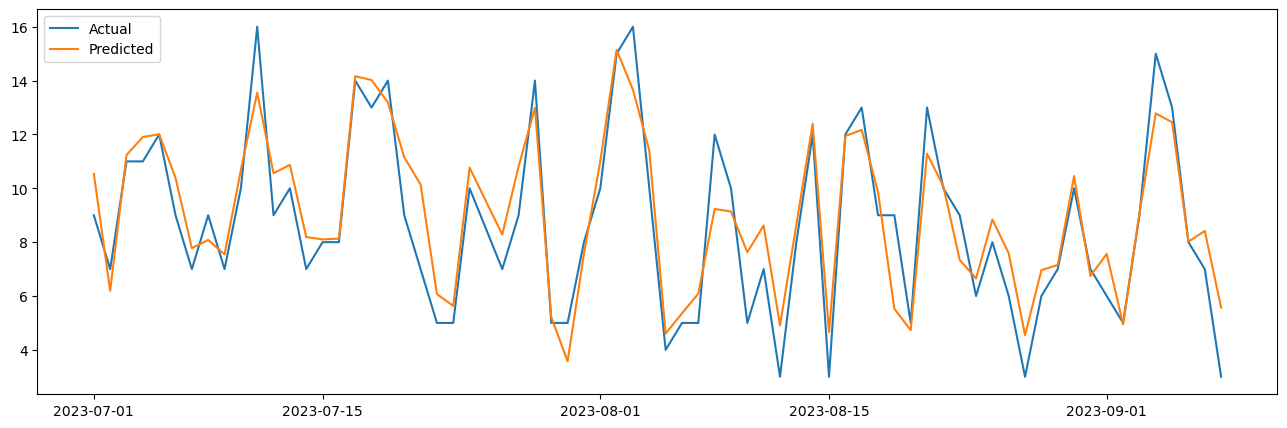

In [313]:
plt.figure(figsize=(16,5))
plt.plot(test.index, test['subscription_count'], label='Actual')
plt.plot(test.index, test['predictions'], label='Predicted')
plt.legend()
plt.show()

## Causal DAG for model explainability

## Counterfactual Generation

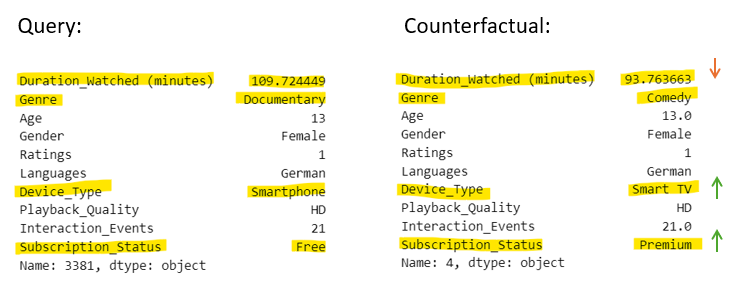

## Causal DAG

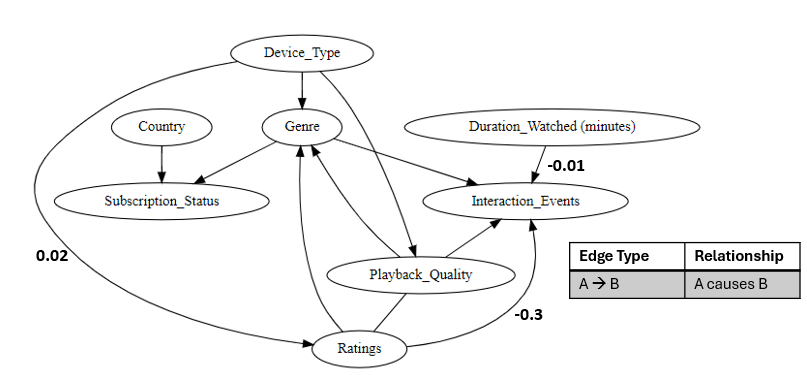